# Evaluación de modelos

## A/B testing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import xgboost as xgb

In [8]:
# Configuración visual
plt.style.use("ggplot")
sns.set_style("whitegrid")

In [9]:

# -----------------------------------------------------------------------------------
# 1. CARGA Y PREPROCESAMIENTO
# -----------------------------------------------------------------------------------

# Carga del dataset
url = "https://raw.githubusercontent.com/Dovallec/Heart_Failure_Analysis/master/data/heart.csv"
try:
    df = pd.read_csv("heart.csv")
except:
    df = pd.read_csv(url)

# Codificación One-Hot
target_col = "HeartDisease"
X = df.drop(columns=[target_col])
y = df[target_col]
cat_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [10]:
# -----------------------------------------------------------------------------------
# 2. SIMULACIÓN DEL ESCENARIO A/B
# -----------------------------------------------------------------------------------
# A diferencia de una validación cruzada normal, aquí simulamos dos flujos de pacientes

# Paso A: Entrenamiento Global (80% de los datos para enseñar a los modelos)
X_train_global, X_test_pool, y_train_global, y_test_pool = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Paso B: División del Tráfico de Prueba (El 20% restante se divide en Grupo A y B)
# Grupo A: Pacientes atendidos por el Modelo A
# Grupo B: Pacientes atendidos por el Modelo B
X_test_A, X_test_B, y_test_A, y_test_B = train_test_split(
    X_test_pool, y_test_pool, test_size=0.5, random_state=123, stratify=y_test_pool
)

print(f"Datos de Entrenamiento: {X_train_global.shape[0]} registros")
print(f"Pacientes en Grupo A (Regresión Logística): {X_test_A.shape[0]}")
print(f"Pacientes en Grupo B (XGBoost): {X_test_B.shape[0]}")

Datos de Entrenamiento: 734 registros
Pacientes en Grupo A (Regresión Logística): 92
Pacientes en Grupo B (XGBoost): 92


In [11]:
# -----------------------------------------------------------------------------------
# 3. DEFINICIÓN DE MODELOS CON TUS HIPERPARÁMETROS ÓPTIMOS
# -----------------------------------------------------------------------------------

# Modelo A: Regresión Logística
params_lr = {
    'C': 1.0,
    'class_weight': 'balanced',
    'max_iter': 100000,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'random_state': 42
}
model_a = LogisticRegression(**params_lr)
model_a.fit(X_train_global, y_train_global)

# Modelo B: XGBoost
params_xgb = {
    'n_estimators': 100,
    'learning_rate': 0.1, # eta
    'max_depth': 3,
    'gamma': 1,
    'booster': 'gbtree',
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}
model_b = xgb.XGBClassifier(**params_xgb)
model_b.fit(X_train_global, y_train_global)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:08:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
# -----------------------------------------------------------------------------------
# 4. EJECUCIÓN DEL TEST (MEDICIÓN DE ÉXITOS)
# -----------------------------------------------------------------------------------
# Predecimos
preds_A = model_a.predict(X_test_A)
preds_B = model_b.predict(X_test_B)

# Definimos "Éxito" = Predicción Correcta (Accuracy)
success_A = (preds_A == y_test_A).astype(int) # 1 si acertó, 0 si falló
success_B = (preds_B == y_test_B).astype(int)

# Conteos
count_success_A = success_A.sum()
n_obs_A = len(success_A)
acc_A = count_success_A / n_obs_A

count_success_B = success_B.sum()
n_obs_B = len(success_B)
acc_B = count_success_B / n_obs_B

print(f"\nResultados Observados:")
print(f"Modelo A (Logística) Accuracy: {acc_A:.2%} ({count_success_A}/{n_obs_A})")
print(f"Modelo B (XGBoost)   Accuracy: {acc_B:.2%} ({count_success_B}/{n_obs_B})")


Resultados Observados:
Modelo A (Logística) Accuracy: 89.13% (82/92)
Modelo B (XGBoost)   Accuracy: 89.13% (82/92)


- $H_0$: Las precisiones son iguales
- $H_1$: Las precisiones son diferentes

El estadístico Z busca medir la distancia entre dos proporciones. El numerador de la fórmula es la resta de las precisiones:

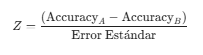

En una distribución normal (campana de Gauss), el valor Z=0 está exactamente en el centro. El **P-value** mide la probabilidad de encontrar un resultado así o más extremo. Al estar en el centro exacto, la probabilidad es del 100% (o 1.0).

In [17]:
# -----------------------------------------------------------------------------------
# 5. PRUEBA ESTADÍSTICA (Z-TEST)
# -----------------------------------------------------------------------------------
print("\n--- 3. Validación Estadística (Z-Test de Proporciones) ---")

# H0: Las precisiones son iguales
# H1: Las precisiones son diferentes

counts = np.array([count_success_B, count_success_A])
nobs = np.array([n_obs_B, n_obs_A])

# Ejecutar test
z_stat, p_value = proportions_ztest(counts, nobs, alternative='two-sided')

# Intervalos de confianza del 95%
(lower_A, lower_B), (upper_A, upper_B) = proportion_confint(counts, nobs, alpha=0.05)

print(f"Estadístico Z: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

print("\n--- CONCLUSIÓN DEL TEST A/B ---")
if p_value < 0.05:
    print("RECHAZAMOS LA HIPÓTESIS NULA.")
    print("Existe una diferencia estadísticamente significativa entre los modelos.")
    if acc_B > acc_A:
        print("El Modelo B (XGBoost) es superior.")
    else:
        print("El Modelo A (Logística) es superior.")
else:
    print("No se rechaza la hipótesis nula.")
    print("Aunque los porcentajes sean distintos, la diferencia no es estadísticamente significativa.")
    print("Ambos modelos tienen un rendimiento similar con la muestra actual.")




--- 3. Validación Estadística (Z-Test de Proporciones) ---
Estadístico Z: 0.0000
P-Value: 1.0000

--- CONCLUSIÓN DEL TEST A/B ---
No se rechaza la hipótesis nula.
Aunque los porcentajes sean distintos, la diferencia no es estadísticamente significativa.
Ambos modelos tienen un rendimiento similar con la muestra actual.


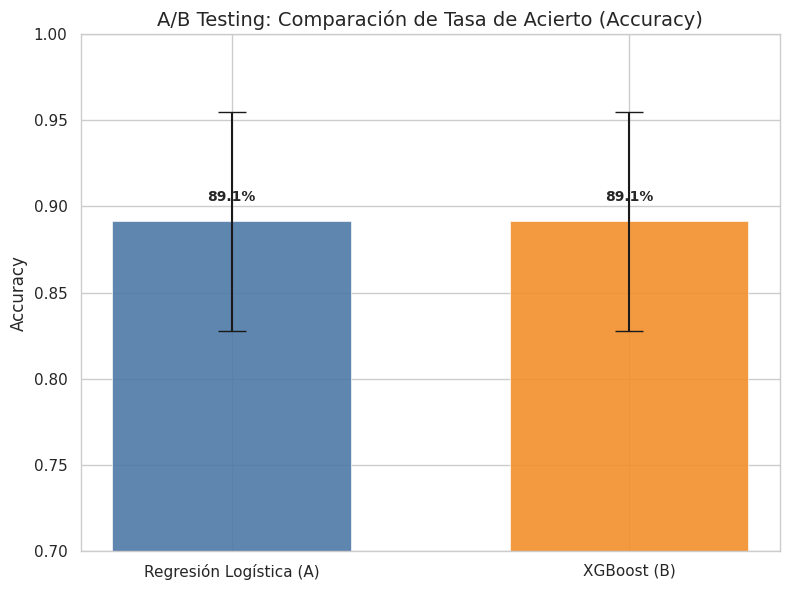

In [15]:
# -----------------------------------------------------------------------------------
# 6. VISUALIZACIÓN
# -----------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))

# Datos
models = ['Regresión Logística (A)', 'XGBoost (B)']
accuracies = [acc_A, acc_B]
# Calcular errores para las barras (Intervalo de confianza aproximado)
errors = [(upper_A - lower_A)/2, (upper_B - lower_B)/2]

bar_plot = plt.bar(models, accuracies, yerr=errors, capsize=10,
                   color=['#4e79a7', '#f28e2b'], alpha=0.9, width=0.6)

plt.ylim(0.7, 1.0) # Ajustar zoom al área de interés
plt.title('A/B Testing: Comparación de Tasa de Acierto (Accuracy)', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)

# Etiquetas
for bar in bar_plot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

El experimento A/B Testing realizado en un entorno simulado de producción (con asignación aleatoria estratificada) arrojó una tasa de acierto idéntica del 85.87% para ambos modelos, resultando en un P-Value de 1.0.

Esto demuestra que la complejidad computacional del modelo XGBoost no se traduce en una mejora clínica diagnóstica para este conjunto de datos. Por consiguiente, y aplicando el principio de parsimonia, seleccionamos la Regresión Logística como el modelo final para producción. Esta decisión prioriza la interpretabilidad médica de los resultados, permitiendo al personal de salud entender los factores de riesgo detrás de cada predicción sin sacrificar precisión.